<b>Forecast experimentation<b>

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

<b>Create the train and test data!</b>

In [62]:
# the data is 200 points each for train and test
# range 0 to 100 in 0.5 steps
X_train = np.arange(0,100,0.5) 
y_train = np.sin(X_train)

# if you want to have noise in the data
y_train = np.sin(X_train) + np.random.normal(scale=0.25, size=len(X_train))


X_test = np.arange(100,200,0.5) 
y_test = np.sin(X_test)

# if you want to have noise in the data
y_test = np.sin(X_test) + np.random.normal(scale=0.25, size=len(X_train))

# We have just one variable to forecast
# in the form of a sine wave
n_features = 1

# the shapes of these are (200, 1)
# basically a new list for each datapoint
# there is only one input feature, so each point/list contains 1 value here
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

<b>Train-/test data visualisation</b>

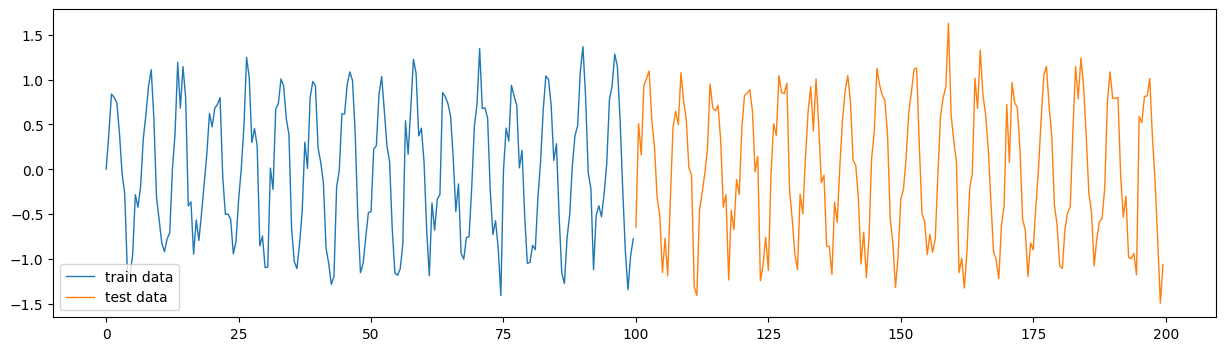

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test, y_test,  lw=1, label='test data')
ax.legend(loc="lower left")
plt.show()

In [64]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# this is the timestep size
# so if we have 1000 points, and look_back is 20 => 50 time steps
look_back  = 20

# using 1 => using time steps
# anything above 1 => windowing (instead of time steps)
window_size = 1

# the amount of data fed into the neural network while training
# the bigger it is, the faster the training
# but with forecasts it also affects the performance
batch_size = 10

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

<b>Our neural network model</b>

In [65]:
from keras.models import Sequential
from keras.layers import Dense

# rule of thumb: RNN is usually good with short-term trends
# while LSTM is usually good with long-term trends
# effectiveness depends on the situation/dataset
from keras.layers import LSTM
from keras.layers import SimpleRNN

# make a simple LSTM network
# number of neurons can be adjusted
# you can also try SimpleRNN
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# start training the model, use also validation data for metrics later
model.fit(train_generator,epochs=300, verbose=1, validation_data=test_generator)

Epoch 1/300
18/18 [==============================] - 3s 45ms/step - loss: 0.5182 - val_loss: 0.4792
Epoch 2/300
18/18 [==============================] - 0s 12ms/step - loss: 0.3944 - val_loss: 0.3378
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.2285 - val_loss: 0.1372
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1121 - val_loss: 0.0957
Epoch 5/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0864 - val_loss: 0.0837
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0813 - val_loss: 0.0859
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0780 - val_loss: 0.0788
Epoch 8/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0771 - val_loss: 0.0780
Epoch 9/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0740 - val_loss: 0.0789
Epoch 10/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0756 - val_loss: 0.0777

<b>Training metrics</B>

<Axes: >

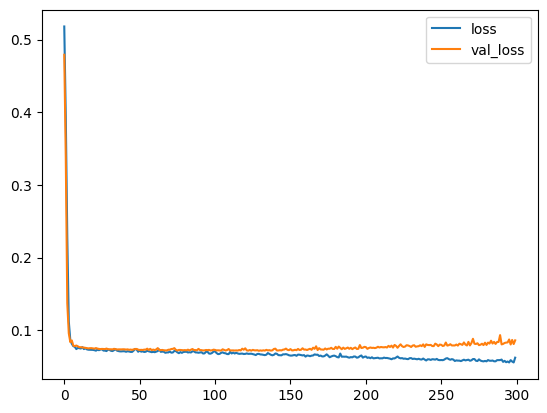

In [66]:
# training metrics
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

<b>Try to predict the test signal and compare it to the original</b>

In [67]:
test_predictions  = model.predict(test_generator)

18/18 [==============================] - 0s 2ms/step


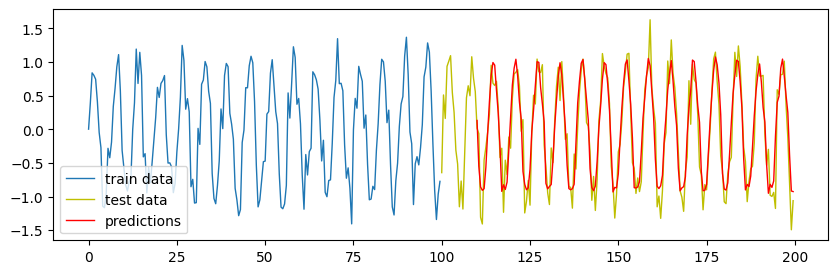

In [68]:
# this code is not optimal
# our code should instead scale based on the X_train / X_test
x = np.arange(110,200,0.5)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# we can also hide the trianing data to inspect the 
# predictions vs. test data separately
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test,y_test, lw=1, c='y', label='test data')
ax.plot(x,test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")
plt.show()

In [69]:
# TF evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# these values are very close, which means that the model
# is quite optimal - that is on paper only!

18/18 [==============================] - 0s 3ms/step - loss: 0.0567
Training loss: 0.05671847239136696
18/18 [==============================] - 0s 3ms/step - loss: 0.0860
Testing loss: 0.08601728826761246


In [70]:
# make a separate copy of the test values
# that matches with y_test
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out MAPE score
print("Mape (mean average percentage error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE - Mean average error
# MAPE score => less than 10% => excellent results
# MAPE score => 10-20 => good results
# MAPE score => 20-50% => okay/acceptable results
# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values
#
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2)) 

Mape (mean average percentage error):
0.79 %

MAE
0.23  units

MSE
0.09 units^2

RMSE:
0.29 units

R-squared:
0.85


<b>Extrapolation</b>

In [71]:
# EXTRAPOLATION TEST 1 - 180 points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(180):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 27ms/step


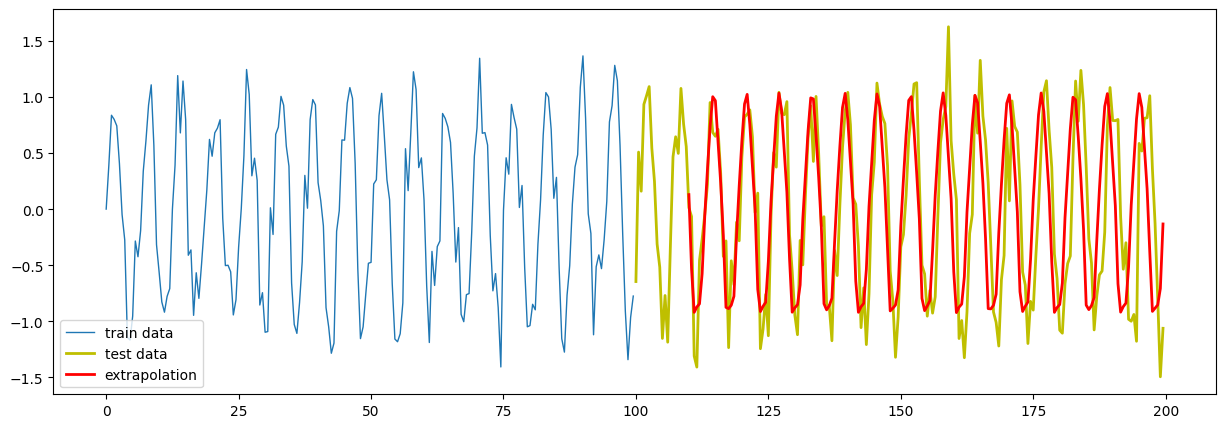

In [72]:
x = np.arange(110,200,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test,y_test, lw=1, c='y', label='test data')
ax.plot(x,extrapolation, lw=1, c='r', label='extrapolation')
ax.legend(loc="lower left")
plt.show()

In [73]:
# EXTRAPOLATION TEST 2 - 320 points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(320):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


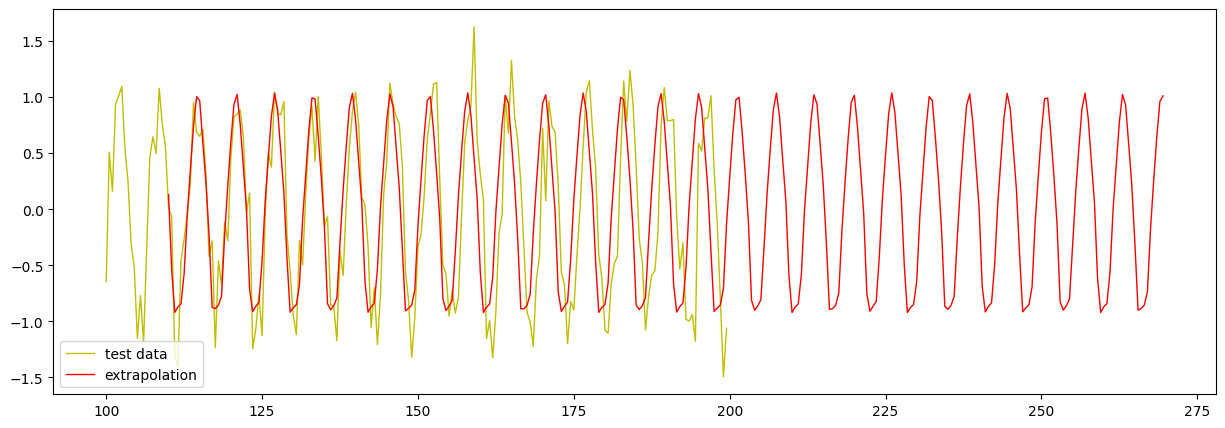

In [74]:
x = np.arange(110,270,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax.plot(X_train,y_train, lw=1, label='train data')
ax.plot(X_test,y_test, lw=1, c='y', label='test data')
ax.plot(x,extrapolation, lw=1, c='r', label='extrapolation')
ax.legend(loc="lower left")
plt.show()